# Livrable 1

## Import des dépendances

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import time

## Chargement des données

In [2]:
#Paramètres

AUTOTUNE = tf.data.AUTOTUNE
current_dir = pathlib.Path().resolve()
DATASET_SIZE = len(list(current_dir.glob('data/*/*')))

batch_size = 32
img_height = 180
img_width = 180
num_classes = 6

In [3]:
full_dataset = tf.data.Dataset.list_files(str(current_dir / 'data/*/*'), shuffle=False)
full_dataset = full_dataset.shuffle(DATASET_SIZE, reshuffle_each_iteration=False)

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

print(DATASET_SIZE)
print(tf.data.experimental.cardinality(train_dataset).numpy())
print(tf.data.experimental.cardinality(test_dataset).numpy())
print(tf.data.experimental.cardinality(val_dataset).numpy())

41555
29088
6233
6234


In [4]:
class_names = np.array(sorted([item.name for item in current_dir.glob('data/*')]))
print(class_names)

['Dataset' 'Painting' 'Photo' 'Schematics' 'Sketch' 'Text']


In [5]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [8]:
from tensorflow.python.data import AUTOTUNE

trainds = train_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
valds = val_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
testds = test_dataset.map(process_path, num_parallel_calls=AUTOTUNE)

print(train_dataset)
print(val_dataset)
print(test_dataset)
print(train_ds)

<TakeDataset shapes: (), types: tf.string>
<SkipDataset shapes: (), types: tf.string>
<TakeDataset shapes: (), types: tf.string>
<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.int64)>


In [9]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


In [14]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=100000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(trainds)
val_ds = configure_for_performance(valds)
test_ds = configure_for_performance(testds)
print(train_ds)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int64)>


Standardisation des données

In [30]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [32]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.build((None, 180, 180, 3))

In [33]:
#Utilisation des rappels de point de contrôle

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [12]:
# # Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True)

#Entraînement du modèle
model.fit(
  train_ds,
  callbacks=[cp_callback],
  validation_data=val_ds,
  epochs=3,
  shuffle=True
)

Epoch 1/3
492/909 [===============>..............] - ETA: 3:36 - loss: 0.6969 - accuracy: 0.7085

KeyboardInterrupt: 

In [34]:
# checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
# # Load the previously saved weights
model.load_weights(latest)

## Validation des données

In [69]:
unique_labels = np.unique(class_names)

def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """

  return unique_labels[np.argmax(prediction_probabilities)]

def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  image = image.astype("uint8")
    
  # Plot image and remove ticks
  plt.imshow(image, vmin=0, vmax=255, cmap="gray")
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color="green"
  else:
    color="red"

  # Change plot title to be predicted, probability of prediction and truth
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

def unbatchify(data):
  """
  Takes a batch dataset of (image, label) Tensors and returns separate arrays of images and labels
  """
  images = []
  labels = []

  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_labels[np.argmax(label)])

  return images,labels



In [78]:
predictions = model.predict(test_ds)

img, label = unbatchify(test_ds)

[[[123.06222  112.10667  105.97333 ]
  [129.04445  117.04444  117.344444]
  [127.679634 113.929634 112.179634]
  ...
  [126.53491  118.78479  119.368164]
  [132.05031  130.60023  128.75026 ]
  [131.4652   113.4652   111.37631 ]]

 [[149.28223  138.28223  136.01555 ]
  [143.16     132.16     130.16    ]
  [118.266655 105.438866  98.78887 ]
  ...
  [147.30022  137.30022  135.30022 ]
  [122.93672  117.93672  113.93672 ]
  [137.70778  122.70779  125.70779 ]]

 [[149.5426   137.5426   139.5426  ]
  [156.93889  145.93889  142.31667 ]
  [163.52779  151.19444  139.7963  ]
  ...
  [148.09274  135.79636  130.37044 ]
  [113.81712  105.19489   98.450455]
  [132.87778  122.71666  120.37409 ]]

 ...

 [[ 97.650154  86.650154  84.650154]
  [103.26668   92.26668   90.26668 ]
  [ 95.453415  82.70341   80.12008 ]
  ...
  [149.88867  118.721924  94.13855 ]
  [135.82774  108.67773   87.5277  ]
  [127.3754   104.3754    87.93106 ]]

 [[108.69563   97.69563   95.69563 ]
  [103.53001   92.53001   90.53001 ]


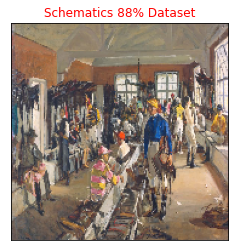

In [84]:
print(img[6150])
print(label[6150])
plot_pred(prediction_probabilities=predictions,
           labels=label,
           images=img,
           n=6150)

In [80]:
# history = model.history
#
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
#
# loss = history.history['loss']
# val_loss = history.history['val_loss']
#
# epochs_range = range(1)
#
# plt.figure(figsize=(16, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')
#
# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [38]:
model.summary()
print(test_ds)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                 